In [1]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


### PARAMETERS

In [2]:
PATH_TO_DATA = 'data/aclImdb/'

### Preparing data

In [3]:
%%time
df = []
for mood in ['pos', 'neg']:
    for data_type in ['train', 'test']:
        file_list = sorted(os.listdir(path=f'{PATH_TO_DATA}{data_type}/{mood}'), key=lambda x: int(x.split('_')[0]))
        for file_name in tqdm(file_list):
            df.append({'data_type': data_type,
                       'mood': mood,
                       'rating': int(file_name[file_name.index('_')+1:-4]),
                       'text': open(f'{PATH_TO_DATA}{data_type}/{mood}/{file_name}', encoding='UTF-8').read()})
df = pd.DataFrame(df)
df = df.sample(df.shape[0], replace=False).reset_index(drop=True)

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:45<00:00, 275.55it/s]

CPU times: total: 16.7 s
Wall time: 3min


<BarContainer object of 8 artists>

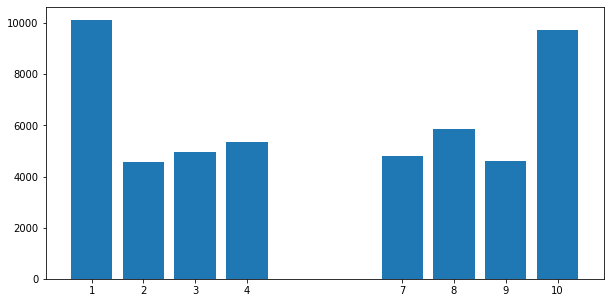

In [61]:
plt.figure(figsize=(10,5))
plt.bar(x=df['rating'].value_counts().index, height=df['rating'].value_counts() ,tick_label=df['rating'].value_counts().index)

In [8]:
plt.show()

### Dividing the data into train and test sets

In [14]:
df['target'] = df['mood'].map({'neg': 0, 'pos': 1})
df_train = df[df['data_type']=='train']
df_test = df[df['data_type']=='test']

### Announcing the catboost model

In [62]:
model = CatBoostClassifier(iterations=1000, depth=4, eval_metric='AUC', random_state=227)

### Training the model

In [63]:
%%time
train_pool = Pool(data=df_train[['text']], label=df_train['rating'], text_features=['text'], has_header=True)
valid_pool = Pool(data=df_test[['text']], label=df_test['rating'], text_features=['text'], has_header=True)
model.fit(X=train_pool, eval_set=valid_pool, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: total: 45min 37s
Wall time: 7min 10s


### Prediction and result analisis

In [22]:
pred = model.predict_proba(df_test[['text']])

In [23]:
df_test['pred'] = list(map(lambda x: model.classes_[np.argmax(x)], pred))

C:\Users\ivanu\AppData\Local\Temp\ipykernel_16400\2813471062.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['pred'] = list(map(lambda x: model.classes_[np.argmax(x)], pred))


In [64]:
# for i in df_test.index:
#     if df_test['rating'][i] == 1 and df_test['pred'][i] == 10:
#         print(df_test['text'][i])
#         print()
#         print()

In [48]:
print(classification_report(df_test['rating'], df_test['pred'], labels=model.classes_))
print('Rating accuracy:', accuracy_score(df_test['rating'], df_test['pred']))
print('Mood accuracy: ', accuracy_score(df_test['target'], df_test['pred'].map(lambda x: 1 if x >= 7 else 0)))
print(confusion_matrix(df_test['rating'], df_test['pred']))
roc_auc_score(df_test['target'], df_test['pred'].map(lambda x: 1 if x >= 7 else 0))

              precision    recall  f1-score   support

           1       0.54      0.81      0.65      5022
           2       0.29      0.08      0.13      2302
           3       0.31      0.16      0.21      2541
           4       0.34      0.43      0.38      2635
           7       0.35      0.31      0.33      2307
           8       0.30      0.26      0.28      2850
           9       0.33      0.06      0.10      2344
          10       0.51      0.74      0.60      4999

    accuracy                           0.44     25000
   macro avg       0.37      0.36      0.34     25000
weighted avg       0.40      0.44      0.40     25000

Rating accuracy: 0.4446
Mood accuracy:  0.87852
[[4091  160  175  311   45   39   10  191]
 [1293  192  238  368   37   45    4  125]
 [ 941  152  402  717  109   65    9  146]
 [ 591  106  292 1128  235  124   12  147]
 [ 124   15   75  355  717  490   38  493]
 [ 133    9   59  241  475  747   82 1104]
 [  97    9   20  102  212  434  137 1333]


0.87852

### Saving the model

In [10]:
model.save_model('atom/atom/modelissimo', format="cbm")